Prepare

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [4]:
# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
# x_train_full: 60,000 images of 28x28 pixels
# y_train_full: 60,000 labels (0-9)
# x_test: 10,000 images of 28x28 pixels
# y_test: 10,000 labels (0-9)

# Normalize the images to [0, 1]
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert labels to one-hot encoding
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# Flatten y_train_full and y_test to work with non-categorical labels temporarily
y_train_full_flat = np.argmax(y_train_full, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

# Combine datasets to balance them together
x_combined = np.concatenate((x_train_full, x_test))
y_combined_flat = np.concatenate((y_train_full_flat, y_test_flat))

# Determine the minimum class size
min_class_size = min(np.bincount(y_combined_flat))

x_combined.shape

(70000, 28, 28)

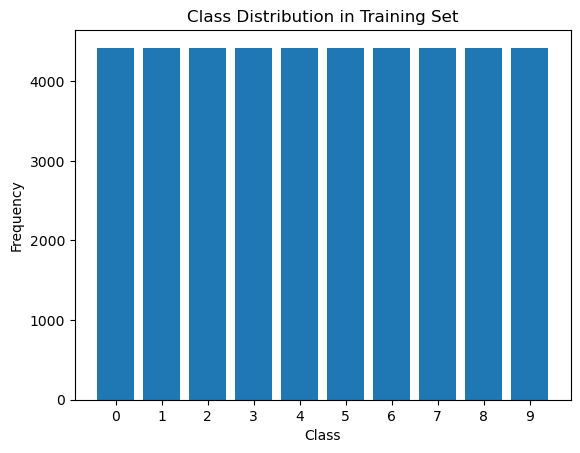

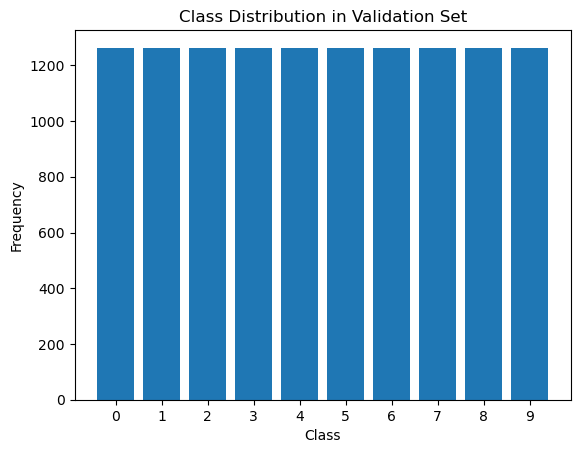

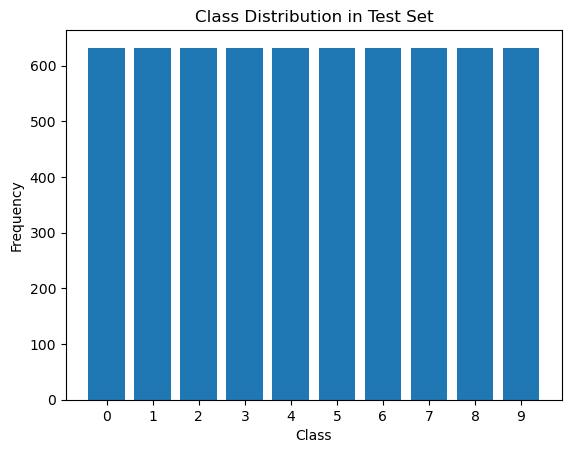

((44191, 10), (12626, 10), (6313, 10))

In [5]:
# Create a balanced dataset
x_balanced = np.empty((0, 28, 28))
y_balanced_flat = np.empty(0, dtype=int)
for i in range(10):
    indices = np.where(y_combined_flat == i)[0]
    balanced_indices = np.random.choice(indices, min_class_size, replace=False)
    x_balanced = np.vstack((x_balanced, x_combined[balanced_indices]))
    y_balanced_flat = np.concatenate((y_balanced_flat, y_combined_flat[balanced_indices]))

# Convert labels back to categorical
y_balanced = to_categorical(y_balanced_flat, 10)

# Split the balanced dataset into training (70%), validation (20%), and test (10%)
x_temp, x_test, y_temp, y_test = train_test_split(x_balanced, y_balanced, test_size=0.1, stratify=y_balanced_flat)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=(2/9), stratify=y_temp)

# Normalise the images to [0, 1]
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape the images to add a dimension for the channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Function to plot class distribution
def plot_class_distribution(labels, dataset_name):
    # Count the number of each class
    class_counts = np.sum(labels, axis=0)
    # Plot
    plt.bar(range(10), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xticks(range(10))
    plt.show()

# Plot the class distribution for each set
plot_class_distribution(y_train, 'Training')
plot_class_distribution(y_val, 'Validation')
plot_class_distribution(y_test, 'Test')
y_train.shape, y_val.shape, y_test.shape

Prepare EMNIST to gauge generalisation

In [4]:
from emnist import extract_training_samples, extract_test_samples

# Load EMNIST data
emnist_images, emnist_labels = extract_training_samples('digits')
emnist_test_images, emnist_test_labels = extract_test_samples('digits')

# Normalize the images to [0, 1]
emnist_images = emnist_images.astype('float32') / 255
emnist_test_images = emnist_test_images.astype('float32') / 255

# Convert labels to one-hot encoding
# emnist_labels = to_categorical(emnist_labels, 10)
# emnist_test_labels = to_categorical(emnist_test_labels, 10)

# Reshape the images to add a dimension for the channel
emnist_images = emnist_images.reshape(emnist_images.shape[0], 28, 28, 1)
emnist_test_images = emnist_test_images.reshape(emnist_test_images.shape[0], 28, 28, 1)

emnist_images.shape, emnist_labels.shape

((240000, 28, 28, 1), (240000,))

In [5]:
# Assuming emnist_test_labels is already loaded and is a flat array of labels (not one-hot encoded)
unique_classes = np.unique(emnist_test_labels)
sample_per_class = 2400
balanced_indices = []
for cls in unique_classes:
    cls_indices = np.where(emnist_test_labels == cls)[0]
    cls_sample_indices = np.random.choice(cls_indices, sample_per_class, replace=False)
    balanced_indices.extend(cls_sample_indices)

# Now, extract the images and labels using the indices
emnist_x_balanced = emnist_test_images[balanced_indices]
emnist_y_balanced = emnist_test_labels[balanced_indices]
# emnist_x_balanced.shape, emnist_y_balanced.shape

# Normalize, reshape, and convert labels to one-hot encoding as necessary
emnist_x_balanced = emnist_x_balanced.astype('float32') / 255
emnist_x_balanced = emnist_x_balanced.reshape(-1, 28, 28, 1)
# emnist_y_balanced_one_hot = to_categorical(emnist_y_balanced, 10)

# Split the balanced dataset into training (70%), validation (20%), and test (10%)
ex_temp, ex_test, ey_temp, ey_test = train_test_split(emnist_x_balanced, emnist_y_balanced, test_size=0.1, stratify=emnist_y_balanced)
ex_train, ex_val, ey_train, ey_val = train_test_split(ex_temp, ey_temp, test_size=(2/9), stratify=ey_temp)

Combine

In [6]:
# Combine MNIST and EMNIST datasets for training, validation, and testing

# One-hot encode EMNIST labels to match the MNIST label format
ey_train_one_hot = to_categorical(ey_train, num_classes=10)
ey_val_one_hot = to_categorical(ey_val, num_classes=10)
ey_test_one_hot = to_categorical(ey_test, num_classes=10)

# Now, concatenate the one-hot encoded label arrays
y_train_combined = np.concatenate([y_train, ey_train_one_hot])
y_val_combined = np.concatenate([y_val, ey_val_one_hot])
y_test_combined = np.concatenate([y_test, ey_test_one_hot])

y_train_combined.shape, y_val_combined.shape, y_test_combined.shape

((60991, 10), (17426, 10), (8713, 10))

In [7]:
# Ensure all datasets are reshaped correctly
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print(x_train.shape, ex_train.shape)
print(x_val.shape, ex_val.shape)
print(x_test.shape, ex_test.shape)

# Concatenate the image arrays for training, validation, and testing
x_train_combined = np.concatenate([x_train, ex_train])
x_val_combined = np.concatenate([x_val, ex_val])
x_test_combined = np.concatenate([x_test, ex_test])

(44191, 28, 28, 1) (16800, 28, 28, 1)
(12626, 28, 28, 1) (4800, 28, 28, 1)
(6313, 28, 28, 1) (2400, 28, 28, 1)


Train the model

In [6]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomTranslation, Resizing, RandomContrast
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# TEST ON MNIST ONLY

# Reshape the images to add a dimension for the channel
x_train_combined = x_train.reshape(-1, 28, 28, 1)
x_val_combined = x_val.reshape(-1, 28, 28, 1)
x_test_combined = x_test.reshape(-1, 28, 28, 1)

y_train_combined = y_train
y_val_combined = y_val
y_test_combined = y_test

x_train_combined.shape, x_val_combined.shape, x_test_combined.shape

((44191, 28, 28, 1), (12626, 28, 28, 1), (6313, 28, 28, 1))

In [9]:
# Reshape the images to add a dimension for the channel
x_train_combined = x_train_combined.reshape(-1, 28, 28, 1)
x_val_combined = x_val_combined.reshape(-1, 28, 28, 1)
x_test_combined = x_test_combined.reshape(-1, 28, 28, 1)

x_train_combined.shape, x_val_combined.shape, x_test_combined.shape

((60991, 28, 28, 1), (17426, 28, 28, 1), (8713, 28, 28, 1))

50% chance of adding Gaussian noise, and just a tad each time.

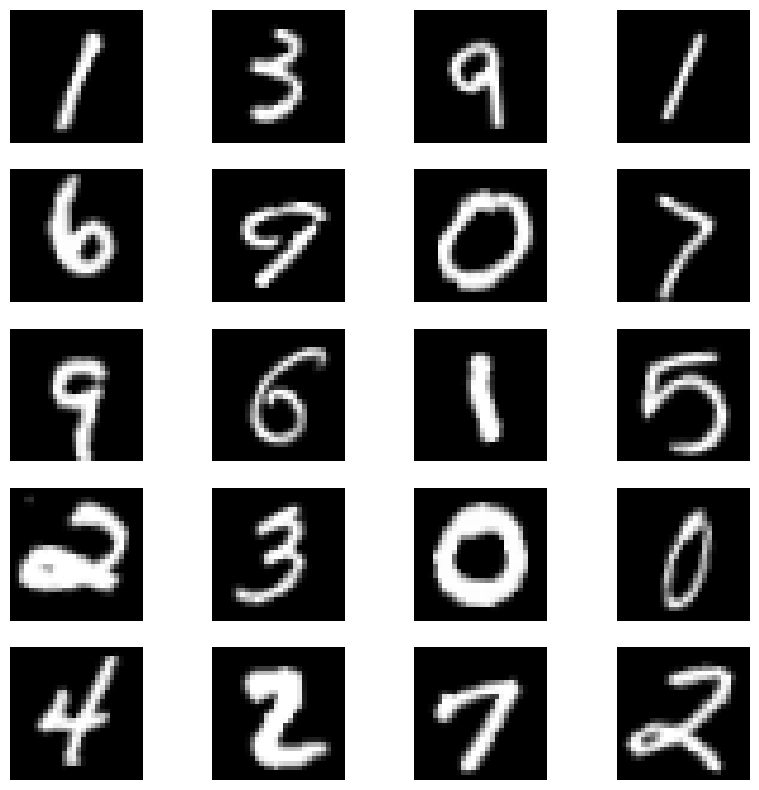

In [22]:
import random

def random_gaussian_noise(x):
    if random.random() < 0.5:  # 50% chance to add Gaussian noise
        scale = np.random.uniform(0.0001, 0.00000005)
        return x + np.random.normal(loc=0, scale=scale, size=x.shape)
    else:
        return x

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest',
    # featurewise_std_normalization=True,  # Normalize the dataset
    # preprocessing_function=random_gaussian_noise  # Add Gaussian noise
)

# Fit the data augmentation on the combined training dataset
datagen.fit(x_train_combined)

# Generate a batch of augmented images and labels
augmented_images, augmented_labels = next(datagen.flow(x_train_combined, y_train_combined, batch_size=64))

# Display the first image in the batch
plt.figure(figsize=(10,  10))
for i in range(20):  # Displaying  20 images in a  5x4 grid
    plt.subplot(5,  4, i +  1)
    plt.imshow(augmented_images[i].reshape(28,  28), cmap='gray')
    plt.axis('off')
plt.show()

In [37]:
# Define the CNN model
cnn_model_3 = Sequential([

    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),           # Standardise inputs to next layer, improving the stability and speed of the training process
    MaxPooling2D((2, 2)),           # Reduces the spatial dimensions of the output from the previous layer, reducing the number of parameters and computation in the network
    Dropout(0.25),                  # Mitigates overfitting for each layer

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flattening the convolutions
    Flatten(),

    # Dense Layers
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation='softmax')
])

# Compile the model
cnn_model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

(44191, 28, 28, 1) (44191, 10)
(12626, 28, 28, 1) (12626, 10)


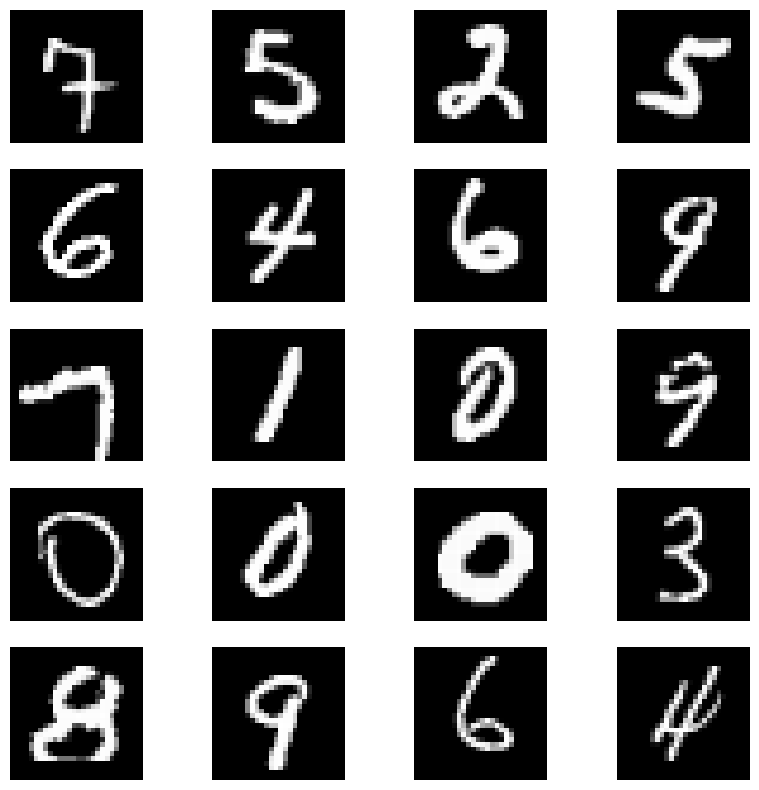

In [24]:
print(x_train_combined.shape, y_train_combined.shape)
print(x_val_combined.shape, y_val_combined.shape)

plt.figure(figsize=(10,  10))
for i in range(20):  # Displaying  20 images in a  5x4 grid
    plt.subplot(5,  4, i +  1)
    plt.imshow(x_val_combined[i].reshape(28,  28), cmap='gray')
    plt.axis('off')

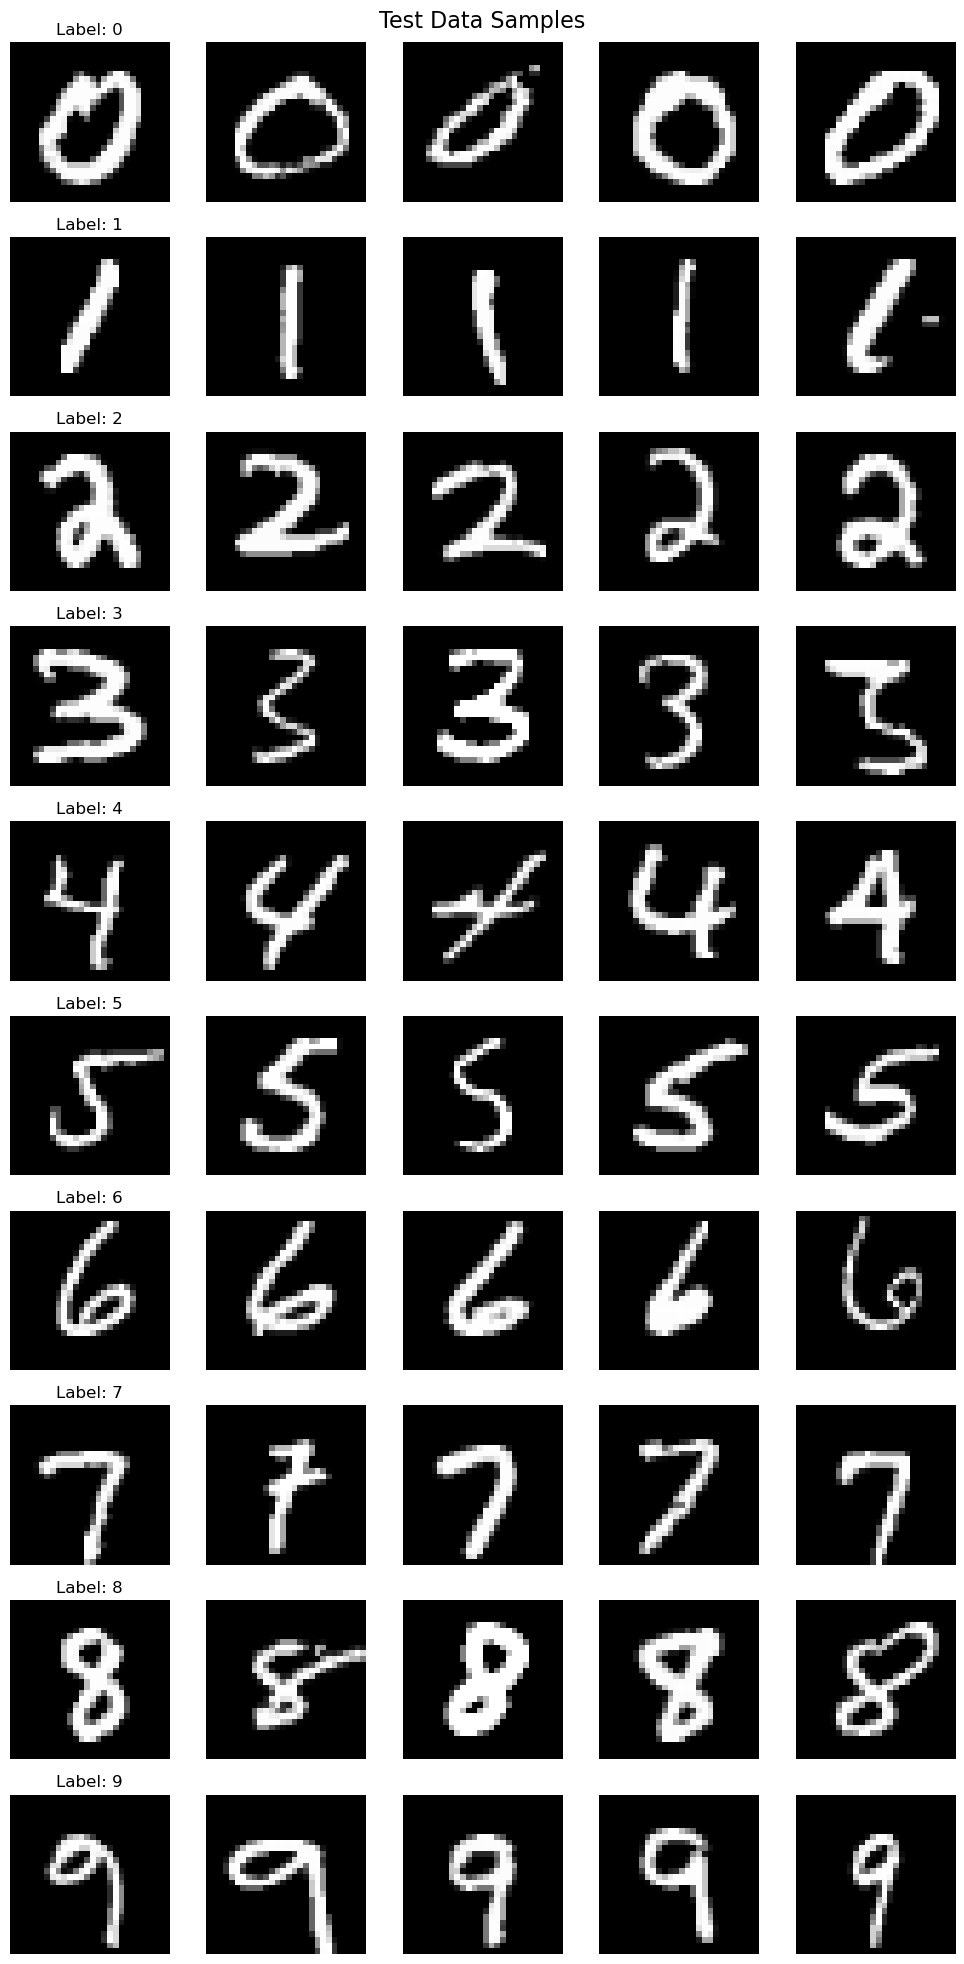

In [38]:
# Check the training and validation data are accurate

def plot_images_with_labels(images, labels, num_classes=10, title="Data", samples_per_class=5):
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(2*samples_per_class, 2*num_classes))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    
    for i in range(num_classes):
        # Find images of a specific class
        class_images = images[labels == i][:samples_per_class]
        
        for j, img in enumerate(class_images):
            idx = i * samples_per_class + j
            axes[idx].imshow(img.reshape(28, 28), cmap='gray')
            axes[idx].axis('off')
            if j == 0:
                axes[idx].set_title(f'Label: {i}')
    plt.tight_layout()
    plt.show()

# Assuming you have y_train_combined and y_test_combined as one-hot encoded labels
y_train_combined_categorical = np.argmax(y_train_combined, axis=1)
y_val_combined_categorical = np.argmax(y_val_combined, axis=1)
y_test_combined_categorical = np.argmax(y_test_combined, axis=1)

# Plot training data samples
# plot_images_with_labels(x_train_combined, y_train_combined_categorical, title="Training Data Samples")
# print('y')
# plot_images_with_labels(x_val_combined, y_val_combined_categorical, title="Validation Data Samples")
plot_images_with_labels(x_test_combined, y_test_combined_categorical, title="Test Data Samples")

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming x_train_combined already normalized but let's ensure its statistics are used for validation
mean = np.mean(x_train_combined)
std = np.std(x_train_combined)

# Normalize validation data using training data's statistics
x_val_combined = (x_val_combined - mean) / std

x_val_combined.shape

# Create a generator for validation data
validation_datagen = ImageDataGenerator(featurewise_std_normalization=True)

# Fit the generator to your training data to compute feature-wise normalization
validation_datagen.fit(x_train_combined)  # Use training data to compute mean and std

/Users/oscarmoxon/anaconda3/envs/NN/lib/python3.11/site-packages/keras/preprocessing/image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Fit

In [40]:
historical = cnn_model_3.fit(
    datagen.flow(x_train_combined, y_train_combined, batch_size=256), 
    epochs=10, 
    validation_data=(x_val_combined, y_val_combined)  # Ensure this data is correctly preprocessed
)

Epoch 1/10


2024-02-17 20:23:03.589175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


173/173 [==============================] - 9s 51ms/step - loss: 0.9742 - accuracy: 0.7033 - val_loss: 7082.3936 - val_accuracy: 0.2298
Epoch 2/10
173/173 [==============================] - 9s 51ms/step - loss: 0.3245 - accuracy: 0.9001 - val_loss: 38439.5820 - val_accuracy: 0.3269
Epoch 3/10
173/173 [==============================] - 9s 51ms/step - loss: 0.2323 - accuracy: 0.9284 - val_loss: 169086.4531 - val_accuracy: 0.4001
Epoch 4/10
173/173 [==============================] - 9s 51ms/step - loss: 0.1905 - accuracy: 0.9417 - val_loss: 701219.3125 - val_accuracy: 0.4229
Epoch 5/10
173/173 [==============================] - 9s 52ms/step - loss: 0.1654 - accuracy: 0.9497 - val_loss: 573152.8125 - val_accuracy: 0.5364
Epoch 6/10
173/173 [==============================] - 10s 58ms/step - loss: 0.1481 - accuracy: 0.9543 - val_loss: 834703.0000 - val_accuracy: 0.4717
Epoch 7/10
173/173 [==============================] - 9s 51ms/step - loss: 0.1350 - accuracy: 0.9590 - val_loss: 440728.0312 

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes with the model
val_predictions = cnn_model_3.predict(x_val_combined)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(y_val_combined, axis=1)

# Confusion Matrix
print(confusion_matrix(val_true_classes, val_pred_classes))

# Classification Report
print(classification_report(val_true_classes, val_pred_classes))

395/395 [==============================] - 1s 3ms/step
[[1096    0  101    0    1    0    1    0   63    0]
 [   0   43  247    0    0    0    0   34  938    0]
 [   0    0 1194    2    1    0    0    3   63    0]
 [   0    0   11 1108    0    2    0    5  137    0]
 [   0    0   20    0 1014    0    1    0  223    5]
 [   4    0    1   28    0  668    9    0  551    2]
 [   2    0    6    0    2    0 1003    0  250    0]
 [   6    0   82    0    0    0    0  907  252   16]
 [   0    0    2    0    0    0    0    0 1260    0]
 [   3    0    1    0    2    2    0    2  738  514]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      1262
           1       1.00      0.03      0.07      1262
           2       0.72      0.95      0.82      1263
           3       0.97      0.88      0.92      1263
           4       0.99      0.80      0.89      1263
           5       0.99      0.53      0.69      1263
           6       0.99      0.79  

In [45]:
!pip install ipywidgets

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed

In [49]:
def view_validation_images(x_val, y_val, index=0):
    """
    Interactive viewer for validation images.

    Parameters:
    - x_val: Array of validation images.
    - y_val: Array of validation labels (assumed to be one-hot encoded).
    - index: Index of the image to display.
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(x_val[index].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {np.argmax(y_val[index])}')
    plt.axis('off')
    plt.show()

# Assuming x_val_combined and y_val_combined are your validation datasets
# Convert x_val_combined back to its original shape if necessary
x_val_reshaped = x_val_combined.reshape(-1, 28, 28, 1)

# Set up the interactive slider and viewer
interact(view_validation_images,
         x_val=fixed(x_val_reshaped),
         y_val=fixed(y_val_combined),
         index=IntSlider(min=0, max=len(x_val_reshaped)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='index', max=12625), Output()), _dom_classes=('widget-int…

<function __main__.view_validation_images(x_val, y_val, index=0)>

In [14]:
cnn_history_1 = cnn_model_1.fit(datagen.flow(x_train_combined, y_train_combined, batch_size=64), epochs=5, validation_data=(x_val_combined, y_val_combined))

Epoch 1/5


2024-02-17 19:58:57.635782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-17 19:58:57.640502: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


953/953 [==============================] - 18s 18ms/step - loss: 0.6657 - accuracy: 0.7918 - val_loss: 5.6762 - val_accuracy: 0.1000
Epoch 2/5
953/953 [==============================] - 19s 19ms/step - loss: 0.2551 - accuracy: 0.9215 - val_loss: 4.8237 - val_accuracy: 0.1000
Epoch 3/5
 30/953 [..............................] - ETA: 16s - loss: 0.2296 - accuracy: 0.9286

KeyboardInterrupt: 

In [126]:
cnn_model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_20 (Bat  (None, 26, 26, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_21 (Bat  (None, 11, 11, 64)      

In [137]:
# Use the data generator to augment the training data
cnn_history_2 = cnn_model_1.fit(datagen.flow(x_train_combined, y_train_combined, batch_size=32),
                            epochs=5,
                            validation_data=(x_val_combined, y_val_combined))

Epoch 1/5
  11/1906 [..............................] - ETA: 21s - loss: 0.1743 - accuracy: 0.9517

2024-02-17 19:55:10.133743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1906/1906 [==============================] - 22s 12ms/step - loss: 0.1209 - accuracy: 0.9646 - val_loss: 7.2255 - val_accuracy: 0.1000
Epoch 2/5
  51/1906 [..............................] - ETA: 19s - loss: 0.0981 - accuracy: 0.9669

KeyboardInterrupt: 

Evaluate on MNIST

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

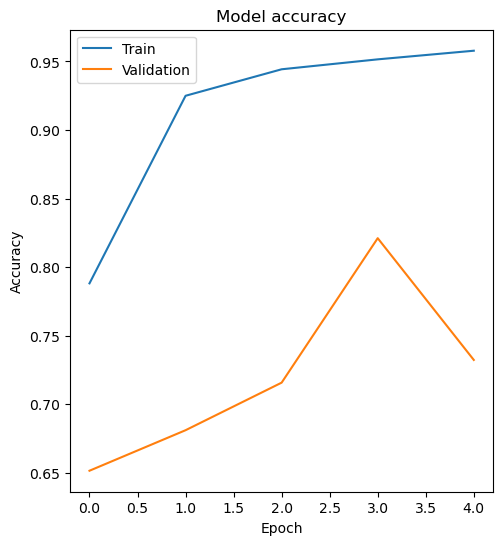

In [34]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [54]:
# Evaluate on MNIST Validation Set
y_val_pred_probs = cnn_model_1.predict(x_val_cnn)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Convert the one-hot encoded validation labels back to class labels
y_val_true = np.argmax(y_val, axis=1)

# Calculate the precision, recall, f1 score, confusion matrix, and classification report
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')
f1 = f1_score(y_val_true, y_val_pred, average='weighted')
conf_mat = confusion_matrix(y_val_true, y_val_pred)
report = classification_report(y_val_true, y_val_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", report)

395/395 [==============================] - 1s 2ms/step
Precision:  0.972881410095359
Recall:  0.9728338349437669
F1 Score:  0.9728028735823184
Confusion Matrix:
 [[1246    0    0    1    0    1    8    2    3    1]
 [   1 1245    8    3    2    0    0    0    3    0]
 [   1    3 1232    7    3    1    0    6    9    1]
 [   3    0   13 1222    0   11    0    5    5    3]
 [   1    0    2    0 1234    0    5    2    0   19]
 [   1    1    1   10    1 1235    8    0    1    5]
 [   4    1    0    0    1    5 1250    0    2    0]
 [   2    3   15    8    1    1    0 1224    2    7]
 [   3    0    3    8    8   21   17    4 1193    6]
 [   7    1    0   13   19    3    1   15    1 1202]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1262
           1       0.99      0.99      0.99      1262
           2       0.97      0.98      0.97      1263
           3       0.96      0.97      0.96      1262
           4

Evaluate on EMNIST

In [59]:
# Evaluate on MNIST Validation Set
y_emnist_pred_probs = cnn_model_1.predict(emnist_x_balanced)
emnist_y_pred = np.argmax(y_emnist_pred_probs, axis=1)
emnist_y_true = emnist_y_balanced

# Calculate the precision, recall, f1 score, confusion matrix, and classification report
precision = precision_score(emnist_y_true, emnist_y_pred, average='weighted', zero_division=0)
recall = recall_score(emnist_y_true, emnist_y_pred, average='weighted', zero_division=0)
f1 = f1_score(emnist_y_true, emnist_y_pred, average='weighted', zero_division=0)
conf_mat = confusion_matrix(emnist_y_true, emnist_y_pred)
report = classification_report(emnist_y_true, emnist_y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", report)

313/313 [==============================] - 1s 2ms/step
Precision:  0.9608986655955285
Recall:  0.9605
F1 Score:  0.9602142306032729
Confusion Matrix:
 [[991   0   3   0   0   1   3   0   1   1]
 [  0 983   5   0   0   0   4   3   5   0]
 [  6   1 966   8   4   0   1   0  14   0]
 [  1   0  10 974   0   9   0   1   4   1]
 [  2   3   2   0 945   0  13   4   7  24]
 [  8   0   0   5   0 981   3   0   3   0]
 [  9   0   1   0   1   2 987   0   0   0]
 [  0   3  15   6   1   0   0 966   7   2]
 [  9   2   3  11   0  11   3   2 958   1]
 [  2   0   1  14  17   6   2  63  41 854]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1000
           1       0.99      0.98      0.99      1000
           2       0.96      0.97      0.96      1000
           3       0.96      0.97      0.97      1000
           4       0.98      0.94      0.96      1000
           5       0.97      0.98      0.98      1000
           6   

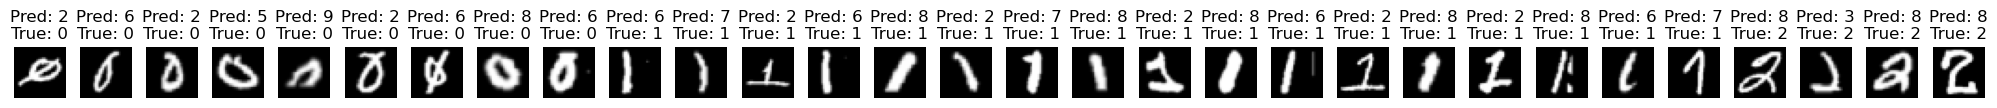

In [62]:
# Identify misclassified images
misclassified_indices = np.where(emnist_y_pred != emnist_y_true)[0]
misclassified_images = emnist_x_balanced[misclassified_indices]
misclassified_predictions = emnist_y_pred[misclassified_indices]
true_labels_misclassified = emnist_y_true[misclassified_indices]

# Plot a sample of misclassified images
num_images_to_show = 30
fig, axes = plt.subplots(1, num_images_to_show, figsize=(20, 4))
for i, ax in enumerate(axes):
    if i < len(misclassified_indices):
        ax.imshow(misclassified_images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f'Pred: {misclassified_predictions[i]}\nTrue: {true_labels_misclassified[i]}')
        ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate with EMNIST only test set

# Assuming emnist_test_labels is already loaded and is a flat array of labels (not one-hot encoded)
unique_classes = np.unique(emnist_test_labels)
sample_per_class = 1000
balanced_indices = []

for cls in unique_classes:
    cls_indices = np.where(emnist_test_labels == cls)[0]
    cls_sample_indices = np.random.choice(cls_indices, sample_per_class, replace=False)
    balanced_indices.extend(cls_sample_indices)

# Now, extract the images and labels using the indices
emnist_x_balanced = emnist_test_images[balanced_indices]
emnist_y_balanced = emnist_test_labels[balanced_indices]

# Normalize, reshape, and convert labels to one-hot encoding as necessary
emnist_x_balanced = emnist_x_balanced.astype('float32') / 255
emnist_x_balanced = emnist_x_balanced.reshape(-1, 28, 28, 1)
emnist_y_balanced_one_hot = to_categorical(emnist_y_balanced, 10)

def plot_class_distribution(labels, dataset_name):
    class_counts = np.sum(labels, axis=0)  # This should result in a shape of (10,)
    plt.figure(figsize=(10, 5))
    plt.bar(range(10), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xticks(range(10))
    plt.show()

# Make sure emnist_y_balanced_one_hot is correctly shaped as (10000, 10)
print("Shape of one-hot encoded labels:", emnist_y_balanced_one_hot.shape)
plot_class_distribution(emnist_y_balanced_one_hot, 'EMNIST Balanced')